# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [42]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [43]:
class GridWorld:
    ## Initialise starting data
    def __init__(self, width=8, height=8):
        # Set information about the gridworld
        self.height = height
        self.width = width
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [44]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [45]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        #type your code here
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(available_actions)
        else:
            state_q_values = self.q_table[self.environment.current_location]
            action = max(state_q_values.items(), key=operator.itemgetter(1))[0]

        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        #type your code here
        # Get the current Q-value for the old state and action
        current_q_value = self.q_table[old_state][action]

        # Get the maximum Q-value for the new state
        max_future_q_value = max(self.q_table[new_state].values())

        # Apply the Q-learning update rule
        new_q_value = current_q_value + self.alpha * (reward + self.gamma * max_future_q_value - current_q_value)

        # Update the Q-table with the new Q-value
        self.q_table[old_state][action] = new_q_value


In [46]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [47]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 2)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

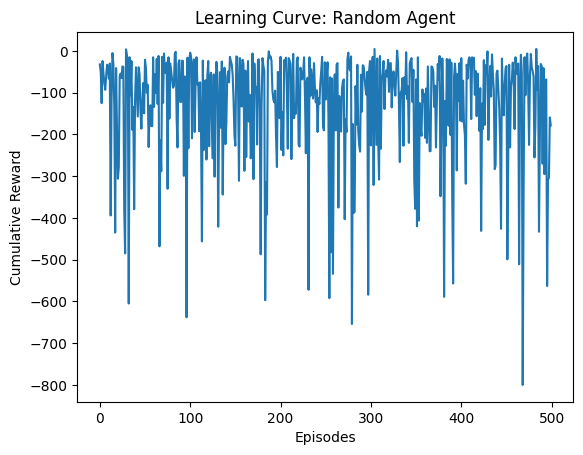

In [48]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curve: Random Agent')

# Show the plot
plt.show()

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

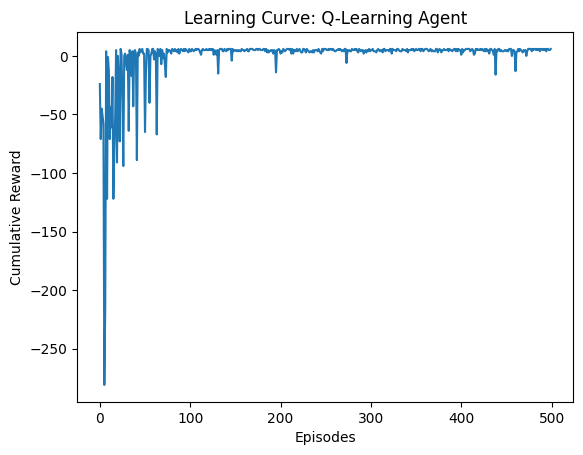

In [49]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve with labels
plt.plot(reward_per_episode)

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curve: Q-Learning Agent')

# Show the plot
plt.show()

Print the final Q-value table with nice formatting.

In [50]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.4
	DOWN
		-0.41883800000000004
	LEFT
		-0.30000000000000004
	RIGHT
		-0.30537614890000003
(0, 1)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		-0.2
	RIGHT
		3.325331075235652
(0, 2)
	UP
		3.5956365084836506
	DOWN
		2.013720603054451
	LEFT
		0.19654848766968147
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		0.8086899794913625
	DOWN
		-0.1
	LEFT
		9.999950781191618
	RIGHT
		0.2798904772507653
(0, 5)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		3.299144990557225
	RIGHT
		-0.1
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.30810000000000004
	LEFT
		-0.3005641
	RIGHT
		-0.319
(0, 7)
	UP
		-0.4
	DOWN
		-0.40981000000000006
	LEFT
		-0.40448000000000006
	RIGHT
		-0.30000000000000004
(1, 0)
	UP
		-0.56281
	DOWN
		-0.6670970441
	LEFT
		-0.6
	RIGHT
		-0.5729510000000001
(1, 1)
	UP
		-0.33904900000000004
	DOWN
		-0.43545303282000003
	LEFT
		-0.41891
	RIGHT
		3.294957380786345
(1, 2)
	UP
		8.999999999999986
	DOWN
		2.7545373151576733
	LEFT
		0.13119821556803202
	RIGHT
		-4

# Large Grid

## Random Agent

In [51]:
lg_env = GridWorld(width=20, height=20)
agent = RandomAgent()

print("Current position of the agent =", lg_env.current_location)
print(lg_env.agent_on_map())
available_actions = lg_env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = lg_env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", lg_env.current_location)
print(lg_env.agent_on_map())

Current position of the agent = (4, 1)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.

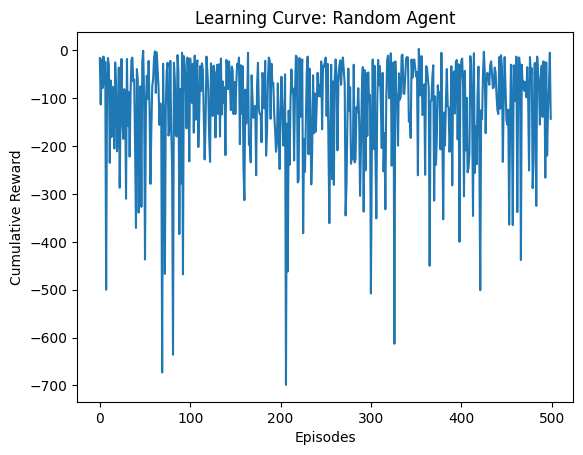

In [52]:
# Initialize environment and agent
large_environment = GridWorld(width=20, height=20)
random_agent = RandomAgent()

reward_per_episode = play(large_environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curve: Random Agent')

# Show the plot
plt.show()

## Q-Agent

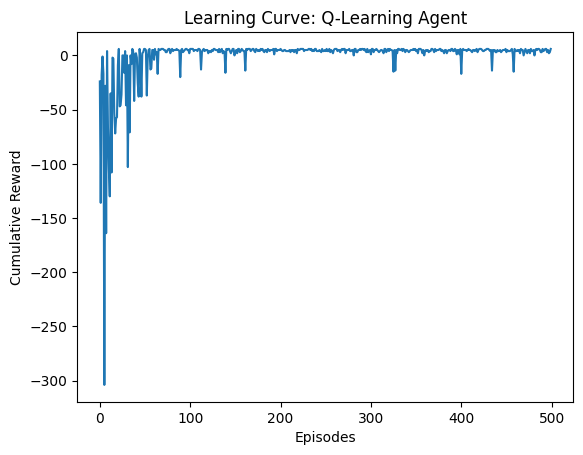

In [53]:
large_environment = GridWorld(width=20, height=20)
agentQ = Q_Agent(large_environment)

# Note the learn=True argument!
reward_per_episode = play(large_environment, agentQ, trials=500, learn=True)

# Simple learning curve with labels
plt.plot(reward_per_episode)

# Adding labels and title
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curve: Q-Learning Agent')

# Show the plot
plt.show()

In [54]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.30000000000000004
	LEFT
		-0.30000000000000004
	RIGHT
		-0.34561000000000003
(0, 1)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		-0.21
	RIGHT
		4.159096169858527
(0, 2)
	UP
		4.908129572209027
	DOWN
		2.6849265016283583
	LEFT
		0.5872043679591719
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		1.5472368788121118
	DOWN
		0.6947131329259936
	LEFT
		9.99950020041947
	RIGHT
		-0.010450944009999998
(0, 5)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		1.7056418132371214
	RIGHT
		-0.1
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.29100000000000004
	LEFT
		-0.306469
	RIGHT
		-0.32
(0, 7)
	UP
		-0.391
	DOWN
		-0.41900000000000004
	LEFT
		-0.39829000000000003
	RIGHT
		-0.4
(0, 8)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 9)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 10)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 11)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 12)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 13)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIG

#  Deep Q-Learning (DQN)

In [55]:
import torch
import torch.nn as nn

# Define the neural network for the DQN
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [56]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)  # Increased memory size
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99  # Slower decay
        self.learning_rate = 0.001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._build_model().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def _build_model(self):
        return DQNetwork(self.state_size, self.action_size)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            act_values = self.model(state)
        return np.argmax(act_values.cpu().data.numpy())

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(self.device)
            reward = torch.FloatTensor([reward]).to(self.device)
            action = torch.LongTensor([action]).to(self.device)

            with torch.no_grad():
                target = reward + self.gamma * torch.max(self.model(next_state)) * (1 - done)
            target_f = self.model(state)

            # Update the Q-value corresponding to the action
            target_f[0][0][action] = target

            loss = self.criterion(self.model(state), target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [57]:
def run_dqn(epsilon, num_episodes):
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    agent.epsilon = epsilon
    scores = []

    for episode in range(num_episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        total_reward = 0

        for time in range(500):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10  # Penalize for failure
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                print(f"Episode: {episode+1}/{num_episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")
                break

        agent.replay(64)  # Increased batch size for replay
        agent.update_epsilon()  # Decay epsilon
        scores.append(total_reward)

    env.close()
    return scores

Running DQN with epsilon: 0.1
Episode: 1/100, Score: -2.0, Epsilon: 0.10
Episode: 2/100, Score: 2.0, Epsilon: 0.10
Episode: 3/100, Score: -2.0, Epsilon: 0.10
Episode: 4/100, Score: 1.0, Epsilon: 0.10
Episode: 5/100, Score: -1.0, Epsilon: 0.10
Episode: 6/100, Score: -1.0, Epsilon: 0.10
Episode: 7/100, Score: -1.0, Epsilon: 0.09


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 8/100, Score: -1.0, Epsilon: 0.09
Episode: 9/100, Score: -1.0, Epsilon: 0.09
Episode: 10/100, Score: 1.0, Epsilon: 0.09
Episode: 11/100, Score: 1.0, Epsilon: 0.09
Episode: 12/100, Score: -1.0, Epsilon: 0.09
Episode: 13/100, Score: 1.0, Epsilon: 0.09
Episode: 14/100, Score: 3.0, Epsilon: 0.09
Episode: 15/100, Score: -3.0, Epsilon: 0.09
Episode: 16/100, Score: 1.0, Epsilon: 0.09
Episode: 17/100, Score: 2.0, Epsilon: 0.09
Episode: 18/100, Score: -1.0, Epsilon: 0.08
Episode: 19/100, Score: 3.0, Epsilon: 0.08
Episode: 20/100, Score: 0.0, Epsilon: 0.08
Episode: 21/100, Score: 3.0, Epsilon: 0.08
Episode: 22/100, Score: 2.0, Epsilon: 0.08
Episode: 23/100, Score: 3.0, Epsilon: 0.08
Episode: 24/100, Score: 4.0, Epsilon: 0.08
Episode: 25/100, Score: 8.0, Epsilon: 0.08
Episode: 26/100, Score: 5.0, Epsilon: 0.08
Episode: 27/100, Score: 3.0, Epsilon: 0.08
Episode: 28/100, Score: 3.0, Epsilon: 0.08
Episode: 29/100, Score: 6.0, Epsilon: 0.08
Episode: 30/100, Score: -1.0, Epsilon: 0.07
Episode

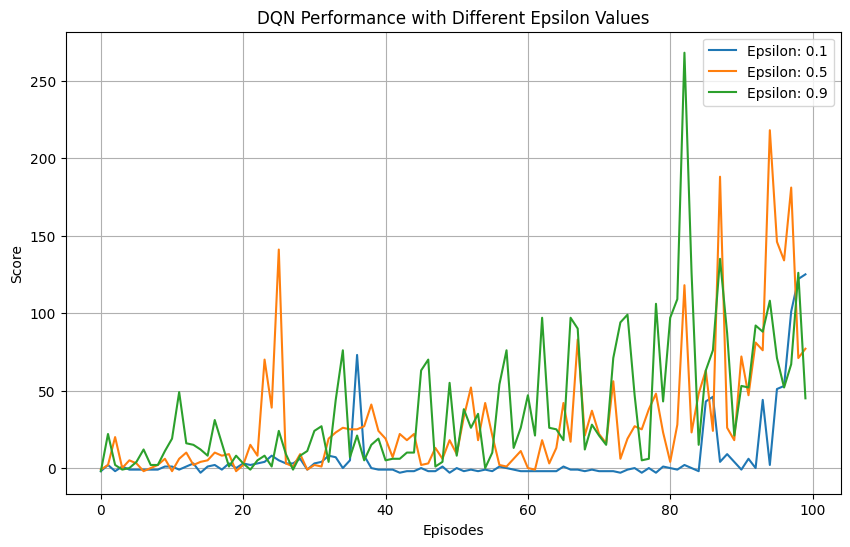

In [58]:
# Run experiments with different epsilon values
num_episodes = 100
epsilon_values = [0.1, 0.5, 0.9]
results = {}

for epsilon in epsilon_values:
    print(f"Running DQN with epsilon: {epsilon}")
    results[epsilon] = run_dqn(epsilon, num_episodes)

# Plotting the results
plt.figure(figsize=(10, 6))

for epsilon, scores in results.items():
    plt.plot(scores, label=f"Epsilon: {epsilon}")

plt.title('DQN Performance with Different Epsilon Values')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()